In this lesson, we will experiment some of the useful techniques we studied in the previous units, for exploring the content of a text corpus. This techniques allow us to identify patterns and recurring themes in the language used across a large number of documents. N-grams enable us to examine the frequency and distribution of sequences of words, while word clouds provide a visual representation of the most commonly used words in a corpus. These techniques can help us to identify key themes, topics, and trends in the language used across a large number of texts, and can be used to test hypotheses and generate new research questions. Additionally, these techniques are relatively simple to implement and can be applied to texts in any language, making them a powerful tool for analyzing large collections of textual data.


For the following examples, we will be using a dataset of newspaper articles in English that we extracted using keywords related to the Spanish flu. The Spanish flu spread in waves between 1918 and 1919, over a period of a little over a year. It is estimated to have infected approximately 500 million people worldwide and caused the death of around 50 million individuals. The media coverage of this event is a complex subject. Indeed, during the same period, it intertwined with the events of World War I, especially during the first wave of the epidemic in 1918.


If you wish, you can also apply the following examples to other datasets extracted from the NewsEye platform (see Unit 2).


Install dependencies 

In [ ]:
!pip install gensim PyLDAvis spacy pandas matplotlib numpy wordcloud
!python -m spacy download en_core_web_sm

Import required libraries

In [1]:
#languange processing imports
import spacy
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

#Word Cloud and Visualization

from wordcloud import WordCloud

Create new data frame from your collection using Pandas. The use of the Pandas library is not mandatory, but it is useful for quickly visualizing and manipulating data, such as adding fields or filtering data.

In [2]:
df = pd.read_csv('./data/spanish_flu_csv.csv', encoding='utf-8')

In [3]:
df

,id,type,date,text
0,new_york_herald_12148-bd6t525546_article_23,article,1920-10-04,"(By Special Cable to the Herald.)\nCnicaco, Su..."
1,new_york_herald_12148-bd6t525546_article_192,article,1920-10-04,"phlegm,'' she says.No Ameriran audience,\nwith..."
2,new_york_herald_12148-bd6t52949f_article_168,article,1919-11-03,Fesigus are already erident that an\ninfluenza...
3,new_york_herald_12148-bd6t52466v_article_4,article,1920-07-08,For some days rumor has been busy- concerning ...
4,new_york_herald_12148-bd6t51517t_article_43,article,1919-06-06,"Sir Boverton Redwood, the petroleum\nexpert, d..."
...,...,...,...,...
313,new_york_herald_12148-bd6t51418w_article_62,article,1919-02-26,"sonville, Pierre Loti, Duc de Bisaccia\nand ot..."
314,new_york_herald_12148-bd6t51418w_article_187,article,1919-02-26,The conditions are cxactiy these:\nThere are 6...
315,new_york_herald_12148-bd6t54710r_article_8,article,1918-06-22,"Barrisu Fnorr, Friday.—The lull on\nthe whole ..."
316,new_york_herald_12148-bd6t54710r_article_54,article,1918-06-22,"(FROM THE HIRRALD'S CORRESPONDENT.)\nLonpon, F..."


At this stage, we only have information that our dataset contains texts, and we lack any further details. Therefore, performing some preliminary statistical analysis based on the document type can provide valuable insights. As an illustration, we may notice that our texts have varying publication years, which enables us to create a graph illustrating the distribution of the texts per year. This representation can provide crucial indications about the characteristics of our corpus, such as potential temporal trends, topics, or language use patterns.


In [4]:
# If year column is not available in your dataset, you can generate it whit pandas
df['year'] = pd.DatetimeIndex(df['date']).year
df.head()


,id,type,date,text,year
0,new_york_herald_12148-bd6t525546_article_23,article,1920-10-04,"(By Special Cable to the Herald.)\nCnicaco, Su...",1920
1,new_york_herald_12148-bd6t525546_article_192,article,1920-10-04,"phlegm,'' she says.No Ameriran audience,\nwith...",1920
2,new_york_herald_12148-bd6t52949f_article_168,article,1919-11-03,Fesigus are already erident that an\ninfluenza...,1919
3,new_york_herald_12148-bd6t52466v_article_4,article,1920-07-08,For some days rumor has been busy- concerning ...,1920
4,new_york_herald_12148-bd6t51517t_article_43,article,1919-06-06,"Sir Boverton Redwood, the petroleum\nexpert, d...",1919


Plot a figure representing the number of articles by year

<Figure size 2000x5000 with 0 Axes>

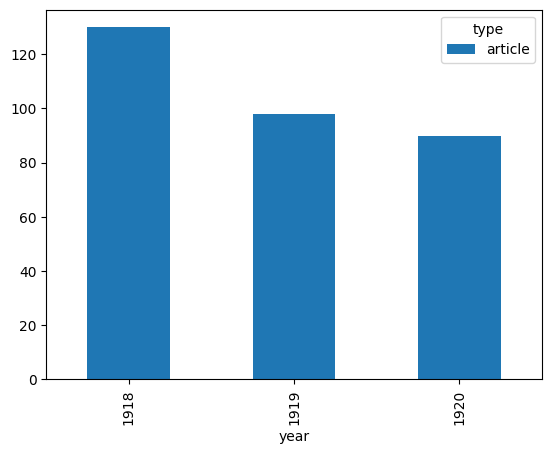

In [5]:
fig = plt.figure(figsize=(20,50))
fig = df.groupby('year')['type'].value_counts().unstack().plot.bar(stacked=True)
plt.savefig('bar.png', dpi = 300)


Here, we will preprocess the text. The code is provided, but all the details are explained in Unit2, so feel free to refer to it. Some of these operations are also explained in detail in OER2. Of course, these steps must be adapted according to the language of your documents.

In [6]:
# from spacy.lang.en import English
# nlp = English()  # default rules for parsing text
nlp = spacy.load('en_core_web_sm')  # More complete model with lemmatization, NER, POS, etc.

doc = nlp(df['text'][0])
data = []
for token in doc:
    data.append([token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop])

# Create the pandas DataFrame
tokens_details = pd.DataFrame(data, columns=['Text', 'Lemma', 'coarse POS', 'fine POS', 'Dependency', 'Shape', 'is Alpha', 'is Stop'])
  
# print dataframe.
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(tokens_details)

,Text,Lemma,coarse POS,fine POS,Dependency,Shape,is Alpha,is Stop
0,(,(,PUNCT,-LRB-,ROOT,(,False,False
1,By,by,ADP,IN,meta,Xx,True,True
2,Special,Special,PROPN,NNP,compound,Xxxxx,True,False
3,Cable,Cable,PROPN,NNP,pobj,Xxxxx,True,False
4,to,to,ADP,IN,prep,xx,True,True
5,the,the,DET,DT,det,xxx,True,True
6,Herald,Herald,PROPN,NNP,pobj,Xxxxx,True,False
7,.,.,PUNCT,.,punct,.,False,False
8,),),PUNCT,-RRB-,punct,),False,False
9,\n,\n,SPACE,_SP,dep,\n,False,False


In [7]:
df['spacy_document'] = df['text'].apply(nlp)

df


,id,type,date,text,year,spacy_document
0,new_york_herald_12148-bd6t525546_article_23,article,1920-10-04,"(By Special Cable to the Herald.)\nCnicaco, Su...",1920,"((, By, Special, Cable, to, the, Herald, ., ),..."
1,new_york_herald_12148-bd6t525546_article_192,article,1920-10-04,"phlegm,'' she says.No Ameriran audience,\nwith...",1920,"(phlegm, ,, '', she, says, ., No, Ameriran, au..."
2,new_york_herald_12148-bd6t52949f_article_168,article,1919-11-03,Fesigus are already erident that an\ninfluenza...,1919,"(Fesigus, are, already, erident, that, an, \n,..."
3,new_york_herald_12148-bd6t52466v_article_4,article,1920-07-08,For some days rumor has been busy- concerning ...,1920,"(For, some, days, rumor, has, been, busy-, con..."
4,new_york_herald_12148-bd6t51517t_article_43,article,1919-06-06,"Sir Boverton Redwood, the petroleum\nexpert, d...",1919,"(Sir, Boverton, Redwood, ,, the, petroleum, \n..."
...,...,...,...,...,...,...
313,new_york_herald_12148-bd6t51418w_article_62,article,1919-02-26,"sonville, Pierre Loti, Duc de Bisaccia\nand ot...",1919,"(sonville, ,, Pierre, Loti, ,, Duc, de, Bisacc..."
314,new_york_herald_12148-bd6t51418w_article_187,article,1919-02-26,The conditions are cxactiy these:\nThere are 6...,1919,"(The, conditions, are, cxactiy, these, :, \n, ..."
315,new_york_herald_12148-bd6t54710r_article_8,article,1918-06-22,"Barrisu Fnorr, Friday.—The lull on\nthe whole ...",1918,"(Barrisu, Fnorr, ,, Friday.—The, lull, on, \n,..."
316,new_york_herald_12148-bd6t54710r_article_54,article,1918-06-22,"(FROM THE HIRRALD'S CORRESPONDENT.)\nLonpon, F...",1918,"((, FROM, THE, HIRRALD, 'S, CORRESPONDENT, ., ..."


In [8]:
# This function filters out the stop words and the punctuation.
def filter_and_lemmatize(document):
    filtered_tokens = []
    for token in document:
        if not token.is_stop and not token.is_punct and token.text != '\n':
            filtered_tokens.append(token)
    # Stemmers are often used but are very crude (Porter stemmer for example), Spacy only make use of lemmatizers.
    lemmas = [token.lemma_ for token in filtered_tokens]
    return lemmas

df['clean_text'] = df['spacy_document'].apply(filter_and_lemmatize) 
df

,id,type,date,text,year,spacy_document,clean_text
0,new_york_herald_12148-bd6t525546_article_23,article,1920-10-04,"(By Special Cable to the Herald.)\nCnicaco, Su...",1920,"((, By, Special, Cable, to, the, Herald, ., ),...","[Special, Cable, Herald, Cnicaco, Sunday.—The,..."
1,new_york_herald_12148-bd6t525546_article_192,article,1920-10-04,"phlegm,'' she says.No Ameriran audience,\nwith...",1920,"(phlegm, ,, '', she, says, ., No, Ameriran, au...","[phlegm, say, Ameriran, audience, väunte, pep,..."
2,new_york_herald_12148-bd6t52949f_article_168,article,1919-11-03,Fesigus are already erident that an\ninfluenza...,1919,"(Fesigus, are, already, erident, that, an, \n,...","[fesigus, erident, influenza, cpidemie, mav, e..."
3,new_york_herald_12148-bd6t52466v_article_4,article,1920-07-08,For some days rumor has been busy- concerning ...,1920,"(For, some, days, rumor, has, been, busy-, con...","[day, rumor, busy-, concern, spirit, ol, revol..."
4,new_york_herald_12148-bd6t51517t_article_43,article,1919-06-06,"Sir Boverton Redwood, the petroleum\nexpert, d...",1919,"(Sir, Boverton, Redwood, ,, the, petroleum, \n...","[Sir, Boverton, Redwood, petroleum, expert, di..."
...,...,...,...,...,...,...,...
313,new_york_herald_12148-bd6t51418w_article_62,article,1919-02-26,"sonville, Pierre Loti, Duc de Bisaccia\nand ot...",1919,"(sonville, ,, Pierre, Loti, ,, Duc, de, Bisacc...","[sonville, Pierre, Loti, Duc, de, Bisaccia, ör..."
314,new_york_herald_12148-bd6t51418w_article_187,article,1919-02-26,The conditions are cxactiy these:\nThere are 6...,1919,"(The, conditions, are, cxactiy, these, :, \n, ...","[condition, cxactiy, 63,000, soldier, eamp, ab..."
315,new_york_herald_12148-bd6t54710r_article_8,article,1918-06-22,"Barrisu Fnorr, Friday.—The lull on\nthe whole ...",1918,"(Barrisu, Fnorr, ,, Friday.—The, lull, on, \n,...","[Barrisu, Fnorr, Friday.—The, lull, british, o..."
316,new_york_herald_12148-bd6t54710r_article_54,article,1918-06-22,"(FROM THE HIRRALD'S CORRESPONDENT.)\nLonpon, F...",1918,"((, FROM, THE, HIRRALD, 'S, CORRESPONDENT, ., ...","[HIRRALD, CORRESPONDENT, Lonpon, friday.—the, ..."


One way to graphically represent a corpus is to create a word cloud. 

A word cloud is a visual representation of text data in which the size of each word indicates its frequency or importance in the text. Words that appear more frequently in the text are displayed with a larger font size, while less frequent words are smaller. Word clouds are useful for quickly identifying the most common themes or topics in a text corpus. 

This representation can be useful to gain a high-level understanding of the main topics or themes present in the corpus. By analyzing the word cloud, it is possible to identify which words or phrases are most frequently mentioned in the text and which ones are less common. This can provide insights into the main subjects covered in the corpus and help to guide further analysis.

To build this wordcloud, we are using N-grams. N-grams are useful in humanities discourse analysis because they can reveal patterns of language use and help identify the most common words and phrases used in a given corpus. This can provide insight into the topics being discussed, the style of language used, and even the social and cultural context in which the language was produced.

For example, in literary studies, analyzing the frequency and context of certain words or phrases can reveal patterns of character development or plot structure. In political discourse analysis, N-grams can be used to analyze the language used by political leaders and identify patterns of rhetoric or manipulation.

In [9]:
from collections import Counter

def ngrams(tokens, n):
    ngrams = [" ".join(tokens[i:i+n]) for i in range(len(tokens) - n+1)]
    return ngrams

df['1-grams'] = df['clean_text'].apply(lambda d: Counter(ngrams(d, 1)))
df['2-grams'] = df['clean_text'].apply(lambda d: Counter(ngrams(d, 2)))
df['3-grams'] = df['clean_text'].apply(lambda d: Counter(ngrams(d, 3)))
df

,id,type,date,text,year,spacy_document,clean_text,1-grams,2-grams,3-grams
0,new_york_herald_12148-bd6t525546_article_23,article,1920-10-04,"(By Special Cable to the Herald.)\nCnicaco, Su...",1920,"((, By, Special, Cable, to, the, Herald, ., ),...","[Special, Cable, Herald, Cnicaco, Sunday.—The,...","{'Special': 1, 'Cable': 1, 'Herald': 1, 'Cnica...","{'Special Cable': 1, 'Cable Herald': 1, 'Heral...","{'Special Cable Herald': 1, 'Cable Herald Cnic..."
1,new_york_herald_12148-bd6t525546_article_192,article,1920-10-04,"phlegm,'' she says.No Ameriran audience,\nwith...",1920,"(phlegm, ,, '', she, says, ., No, Ameriran, au...","[phlegm, say, Ameriran, audience, väunte, pep,...","{'phlegm': 1, 'say': 1, 'Ameriran': 1, 'audien...","{'phlegm say': 1, 'say Ameriran': 1, 'Ameriran...","{'phlegm say Ameriran': 1, 'say Ameriran audie..."
2,new_york_herald_12148-bd6t52949f_article_168,article,1919-11-03,Fesigus are already erident that an\ninfluenza...,1919,"(Fesigus, are, already, erident, that, an, \n,...","[fesigus, erident, influenza, cpidemie, mav, e...","{'fesigus': 1, 'erident': 1, 'influenza': 1, '...","{'fesigus erident': 1, 'erident influenza': 1,...","{'fesigus erident influenza': 1, 'erident infl..."
3,new_york_herald_12148-bd6t52466v_article_4,article,1920-07-08,For some days rumor has been busy- concerning ...,1920,"(For, some, days, rumor, has, been, busy-, con...","[day, rumor, busy-, concern, spirit, ol, revol...","{'day': 1, 'rumor': 1, 'busy-': 1, 'concern': ...","{'day rumor': 1, 'rumor busy-': 1, 'busy- conc...","{'day rumor busy-': 1, 'rumor busy- concern': ..."
4,new_york_herald_12148-bd6t51517t_article_43,article,1919-06-06,"Sir Boverton Redwood, the petroleum\nexpert, d...",1919,"(Sir, Boverton, Redwood, ,, the, petroleum, \n...","[Sir, Boverton, Redwood, petroleum, expert, di...","{'Sir': 2, 'Boverton': 2, 'Redwood': 1, 'petro...","{'Sir Boverton': 2, 'Boverton Redwood': 1, 'Re...","{'Sir Boverton Redwood': 1, 'Boverton Redwood ..."
...,...,...,...,...,...,...,...,...,...,...
313,new_york_herald_12148-bd6t51418w_article_62,article,1919-02-26,"sonville, Pierre Loti, Duc de Bisaccia\nand ot...",1919,"(sonville, ,, Pierre, Loti, ,, Duc, de, Bisacc...","[sonville, Pierre, Loti, Duc, de, Bisaccia, ör...","{'sonville': 1, 'Pierre': 1, 'Loti': 1, 'Duc':...","{'sonville Pierre': 1, 'Pierre Loti': 1, 'Loti...","{'sonville Pierre Loti': 1, 'Pierre Loti Duc':..."
314,new_york_herald_12148-bd6t51418w_article_187,article,1919-02-26,The conditions are cxactiy these:\nThere are 6...,1919,"(The, conditions, are, cxactiy, these, :, \n, ...","[condition, cxactiy, 63,000, soldier, eamp, ab...","{'condition': 1, 'cxactiy': 1, '63,000': 1, 's...","{'condition cxactiy': 1, 'cxactiy 63,000': 1, ...","{'condition cxactiy 63,000': 1, 'cxactiy 63,00..."
315,new_york_herald_12148-bd6t54710r_article_8,article,1918-06-22,"Barrisu Fnorr, Friday.—The lull on\nthe whole ...",1918,"(Barrisu, Fnorr, ,, Friday.—The, lull, on, \n,...","[Barrisu, Fnorr, Friday.—The, lull, british, o...","{'Barrisu': 1, 'Fnorr': 1, 'Friday.—The': 1, '...","{'Barrisu Fnorr': 1, 'Fnorr Friday.—The': 1, '...","{'Barrisu Fnorr Friday.—The': 1, 'Fnorr Friday..."
316,new_york_herald_12148-bd6t54710r_article_54,article,1918-06-22,"(FROM THE HIRRALD'S CORRESPONDENT.)\nLonpon, F...",1918,"((, FROM, THE, HIRRALD, 'S, CORRESPONDENT, ., ...","[HIRRALD, CORRESPONDENT, Lonpon, friday.—the, ...","{'HIRRALD': 1, 'CORRESPONDENT': 1, 'Lonpon': 1...","{'HIRRALD CORRESPONDENT': 1, 'CORRESPONDENT Lo...","{'HIRRALD CORRESPONDENT Lonpon': 1, 'CORRESPON..."


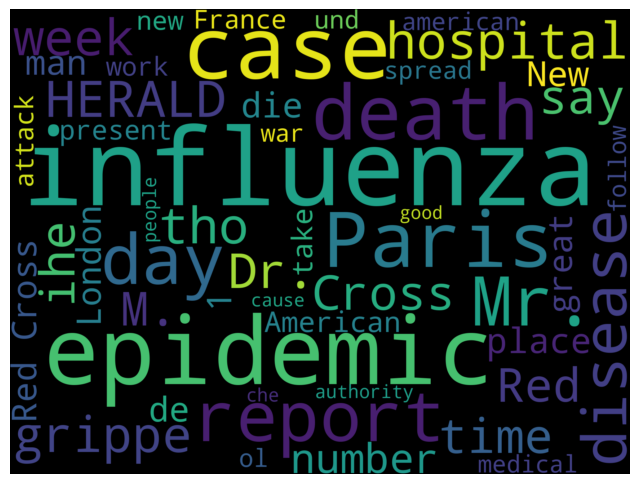

In [10]:
def display_word_cloud(frequencies):
    # Set parameters for the wordcloud
    WC_height = 1500
    WC_width = 2000
    WC_max_words = 50

    # Create the wordcloud using WordCloud library and generate it from the dictionary of words
    wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
    wordCloud.generate_from_frequencies(frequencies)

    # Plot the wordcloud
    plt.figure(figsize=(8,8))
    plt.plot
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
import functools
all_frequencies = functools.reduce(lambda a, b: a+b, df['1-grams'].values)
all_frequencies = all_frequencies + functools.reduce(lambda a, b: a+b, df['2-grams'].values)
all_frequencies += functools.reduce(lambda a, b: a+b, df['3-grams'].values)

display_word_cloud(all_frequencies)

## Adding POS 

For now, the word cloud is difficult to read. We have removed the stop words, but we have kept all types of words.

As we have seen in Unit2, we can use POS tags which are labels assigned to each token in a dataset that indicate the part of speech. The tags we are using include noun, adjective, adverb, and verb. By using these tags, you can limit your dataset to specific parts of speech, such as identifying the most frequently used nouns or verbs, depending on the nature of the dataset. A list of all possible POS tags used in Spacy is available at [this address](https://universaldependencies.org/u/pos/). For a list of more fine-grained POS (available through the tag_ attribute of a token), you have to look at the [labels of the model](https://spacy.io/models/en#en_core_web_sm-labels) we are using.


In [ ]:
# TODO Printer la liste de tous les types 
def filter_pos_tags(document):
    allowed_postags = ['NOUN', 'ADJ', 'ADV']
    return [tok.text for tok in document if tok.pos_ in allowed_postags]


df['pos_filtered_text'] = df['spacy_document'].apply(filter_pos_tags) 


df


Let's build another wordcloud by using our new function (can be long to run). Here we decided to keep 'NOUN, ADJ and ADV'. Feel free to try with 'NOUN' only for example. 

In [ ]:
df['1-grams'] = df['pos_filtered_text'].apply(lambda d: Counter(ngrams(d, 1)))
df['2-grams'] = df['pos_filtered_text'].apply(lambda d: Counter(ngrams(d, 2)))
df['3-grams'] = df['pos_filtered_text'].apply(lambda d: Counter(ngrams(d, 3)))

all_frequencies = functools.reduce(lambda a, b: a+b, df['1-grams'].values)
all_frequencies = all_frequencies + functools.reduce(lambda a, b: a+b, df['2-grams'].values)
all_frequencies += functools.reduce(lambda a, b: a+b, df['3-grams'].values)

display_word_cloud(all_frequencies)

The wordcloud is significantly easier to read and interpret now. But here, we have produced a representation of the entire text corpus. To move forward, we could, for example, display a word cloud for each year in our corpus, or for each different newspaper title we have, etc. It depends a lot on the case study. With the Pandas library, however, it is very easy to test several hypotheses and select only the texts we want to analyze. 

Let's try to make a wordcloud for 1918 only, by using our process_words function only for 1918 data. 



In [ ]:
filtered_df = df.loc[df['year'] == 1918]

df['1-grams'] = filtered_df['pos_filtered_text'].apply(lambda d: Counter(ngrams(d, 1)))
df['2-grams'] = filtered_df['pos_filtered_text'].apply(lambda d: Counter(ngrams(d, 2)))
df['3-grams'] = filtered_df['pos_filtered_text'].apply(lambda d: Counter(ngrams(d, 3)))

all_frequencies = functools.reduce(lambda a, b: a+b, filtered_df['1-grams'].values)
all_frequencies = all_frequencies + functools.reduce(lambda a, b: a+b, filtered_df['2-grams'].values)
all_frequencies += functools.reduce(lambda a, b: a+b, filtered_df['3-grams'].values)

display_word_cloud(all_frequencies)


To conclude, the techniques presented here do not provide answers to research questions, but are a means of analyzing large volumes of text, testing hypotheses, and even raising new questions about a dataset. This is an experimental process, feel free to replicate the code with other texts or languages and test other hypotheses.